In [10]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import transforms
import matplotlib.cm as cm

from esa_4d_antarctica.modeling import read_good_parameters, read_best_parameters, depth_v2
from esa_4d_antarctica.location import site_name

In [11]:


files = glob(f"DreamData/metadata_*_*.json")
df = pd.concat((pd.read_json(f, typ='series') for f in files), axis=1).T
df = df.sort_values('meltdays')
locations = df.site.unique()

In [12]:
simuls = pd.read_csv("DreamData/best-lband-adjusted-simulations.csv")
simuls = simuls.set_index("site")


In [13]:
def draw_dodge(func, *args, **kwargs):
    dodge = kwargs.pop("dodge", 0)
    ax = kwargs.pop("ax", plt.gca())
    
    artist = func(*args, **kwargs)
    
    
    
    def iterate(artist):
        if hasattr(artist, '__iter__'):
            for obj in artist:
                iterate(obj)
        else:
            trans = artist.get_transform()  + transforms.ScaledTranslation(dodge / 72., 0,
                                   ax.figure.dpi_scale_trans)
    #print(trans)
            artist.set_transform(trans)
    iterate(artist)
    return artist

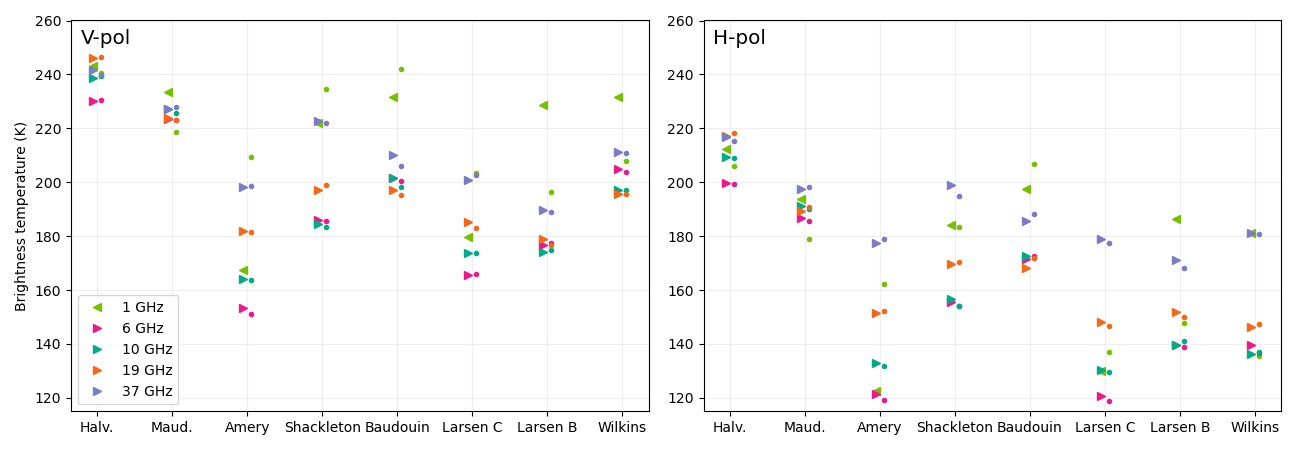

In [14]:
frequency_color = {'10': '#03aa87', '19': '#f46817', '37': "#7b7bc6", '06': '#ee188d',
                   '01': '#77C000'}
frequency_symbol = {'10': '>', '19': '>', '37': ">", '06': '>',
                   '01': '<'}
frequency_dodge = {'10': -3, '19': -3, '37': -3, '06': -3,
                   '01': -3}

f, axs = plt.subplots(1, 2, figsize=(13, 4.5))

pol = 'V'

freqs = ['01', '06', '10', '19', '37']
labels = ['1 GHz', '6 GHz', '10 GHz', '19 GHz', '37 GHz']

wdf = df[df.season=="winter"].set_index("site")

for i, pol in enumerate(['V', 'H']):
    for freq, label in zip(freqs, labels):
        ch = f'{freq}{pol}'
        x_obs = wdf[f'{freq}H'] / wdf[f'{freq}V'] if pol == 'H/V' else wdf[ch]
        draw_dodge(axs[i].plot, site_name(wdf.index), x_obs, frequency_symbol[freq], color=frequency_color[freq], label=label, dodge=frequency_dodge[freq])
        
        x_mod = simuls[f'{freq}H'] / simuls[f'{freq}V'] if pol == 'H/V' else simuls[ch]
        draw_dodge(axs[i].plot, site_name(simuls.index), x_mod, '.', color=frequency_color[freq], dodge=3)
        
        
    axs[i].grid(alpha=0.2)
    
axs[0].set_ylabel('Brightness temperature (K)')
titles = ['V-pol', 'H-pol']

for i in [0, 1]:
    axs[i].set_ylim((115, 260))
    axs[i].annotate(titles[i], xy=(0.017, 0.94), fontsize='x-large', xycoords=('axes fraction', 'axes fraction'))

axs[0].legend(loc='lower left')
plt.tight_layout()
plt.savefig("fig-tb-experiment0.pdf")

In [15]:
def compute_stats(exclude_sites=None):
    residual = {}
    for i, pol in enumerate(['V', 'H', 'H/V']):
        for freq in freqs:
            ch = f'{freq}{pol}'
            x_obs = wdf[f'{freq}H'] / wdf[f'{freq}V'] if pol == 'H/V' else wdf[ch]        
            x_mod = simuls[f'{freq}H'] / simuls[f'{freq}V'] if pol == 'H/V' else simuls[ch]

            residual[ch] = x_mod - x_obs

    residual = pd.DataFrame(residual)
    if exclude_sites is not None:
        residual = residual.drop(exclude_sites)
    print("bias: \n", residual.mean(), " std:\n", residual.std(), " rmse:\n", np.sqrt((residual**2).mean()))

    print("----")
    for freq in freqs:
        mse = (residual[f'{freq}H']**2 + residual[f'{freq}V']**2).mean() / 2
        print(np.sqrt(mse))
    
compute_stats()

bias: 
 01V      1.906331
06V     -0.510091
10V     -0.637550
19V     -0.610151
37V     -0.451715
01H     -6.364206
06H     -1.166399
10H     -0.518274
19H      0.704274
37H     -0.711661
01H/V   -0.034713
06H/V   -0.004101
10H/V    0.000120
19H/V    0.006026
37H/V   -0.001507
dtype: float64  std:
 01V      25.058568
06V       0.991669
10V       1.347324
19V       1.535850
37V       1.769639
01H      27.366022
06H       1.138339
10H       1.102888
19H       1.795667
37H       2.191514
01H/V     0.051384
06H/V     0.006567
10H/V     0.005674
19H/V     0.009784
37H/V     0.014441
dtype: float64  rmse:
 01V      23.517535
06V       1.058619
10V       1.412389
19V       1.560854
37V       1.715872
01H      26.377830
06H       1.579343
10H       1.154523
19H       1.821365
37H       2.169989
01H/V     0.059290
06H/V     0.007387
10H/V     0.005309
19H/V     0.010958
37H/V     0.013592
dtype: float64
----
24.98864113147431
1.344432709175525
1.2899156597576509
1.6961184565651382
1.95615295995

Text(0, 0.5, 'Seasonal Brigthness temperature difference (K)')

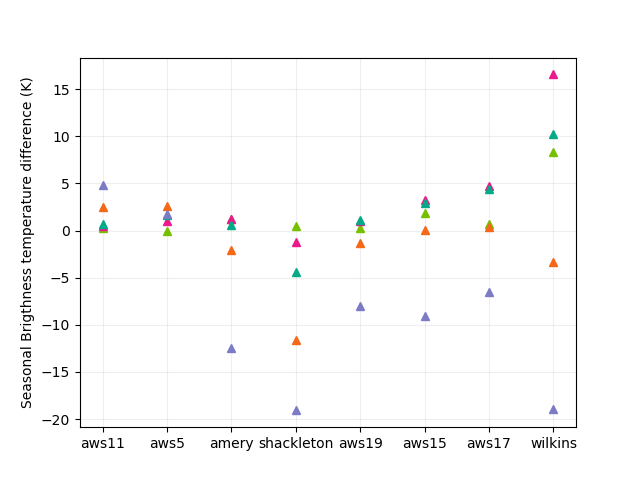

In [16]:
plt.figure()

wdf = df[df.season=="winter"].set_index('site')
sdf = df[df.season=="spring"].set_index('site')
adf = df[df.season=="autumn"].set_index('site')

for freq in freqs:
    
    x = adf[f'{freq}V'] - wdf[f'{freq}V']
    plt.plot(x.index, x, '^', color=frequency_color[freq])

plt.grid(alpha=0.2)
plt.ylabel("Seasonal Brigthness temperature difference (K)")

In [17]:
season = 'winter'

props = {}
for season in ['winter', 'autumn']:
    p = []
    for location in locations:

        params = read_good_parameters(f"DreamData/smrt3-1_dream_13params_{location}_{season}.nc", burn=0.5)

        mparam = np.array(params[0:1000]).mean(axis=0)

        #mparam = read_best_parameters(f"DreamData/smrt2_dream_12params_{location}_{season}.nc")

        p.append({'grain_size_0': mparam[0] * 1e3,
                   'grain_size_1': mparam[1] * 1e3,
                   'grain_size_2': mparam[2] * 1e3,
                   'grain_size_3': mparam[3] * 1e3,
                   'grain_size': np.mean(mparam[0:4]) * 1e3,
                   'density': np.mean(mparam[4:7]),
                   'density_0': np.mean(mparam[4]),
                   'density_1': np.mean(mparam[5]),
                   'density_2': np.mean(mparam[6]),
                   'density_3': np.mean(mparam[7]),
                   'density': np.mean(mparam[4:7]),
                   'layering': np.mean(mparam[9:12]),
                   'layering_0': np.mean(mparam[8]),
                   'layering_1': np.mean(mparam[9]),
                   'layering_2': np.mean(mparam[10]),
                   'layering_3': np.mean(mparam[11]),
                   'sigma': np.mean(mparam[12])
                  })
    

    props[season] = pd.DataFrame(p, index=locations)
    
print("mean sigma: ", props['winter']['sigma'].mean())
props['winter']

mean sigma:  2.503699376000278


,grain_size_0,grain_size_1,grain_size_2,grain_size_3,grain_size,density,density_0,density_1,density_2,density_3,layering,layering_0,layering_1,layering_2,layering_3,sigma
aws11,0.081884,0.078229,0.622714,1.811511,0.648585,657.588783,406.578711,735.175363,831.012275,862.272274,2.948486,0.928461,0.428528,3.448021,4.968910,2.188862
aws5,0.060683,0.437293,0.405329,1.933738,0.709261,679.552154,502.786191,753.714691,782.155579,833.777369,2.688870,0.866417,1.905316,2.127999,4.033295,2.170065
amery,0.016606,0.589776,2.253240,0.795259,0.913720,529.016676,268.186350,548.377828,770.485849,811.084135,2.369741,1.354919,0.875643,2.250627,3.982954,2.402939
shackleton,0.010352,0.859737,1.195094,1.086632,0.787954,603.500102,450.565523,644.492106,715.442678,775.052692,2.960552,0.797313,1.451245,3.913142,3.517270,2.871692
aws19,0.049530,0.701014,1.136049,1.835216,0.930452,604.195927,327.183511,731.768097,753.636173,800.756913,2.999676,1.200867,0.918233,3.373646,4.707150,3.336199
aws15,0.029772,0.743390,2.131926,1.123882,1.007243,552.979496,292.373548,623.423651,743.141289,818.636315,4.012392,1.622673,4.038987,3.293555,4.704634,2.417613
aws17,0.088026,1.124624,1.968629,1.067777,1.062264,644.347068,383.072722,748.539223,801.429259,867.233816,3.854475,1.356744,4.962028,3.544497,3.056900,2.284410
wilkins,0.019143,0.672175,0.661550,1.847260,0.800032,560.972184,263.266703,667.386343,752.263507,784.086824,2.489220,2.313921,4.688390,1.837017,0.942252,2.357814


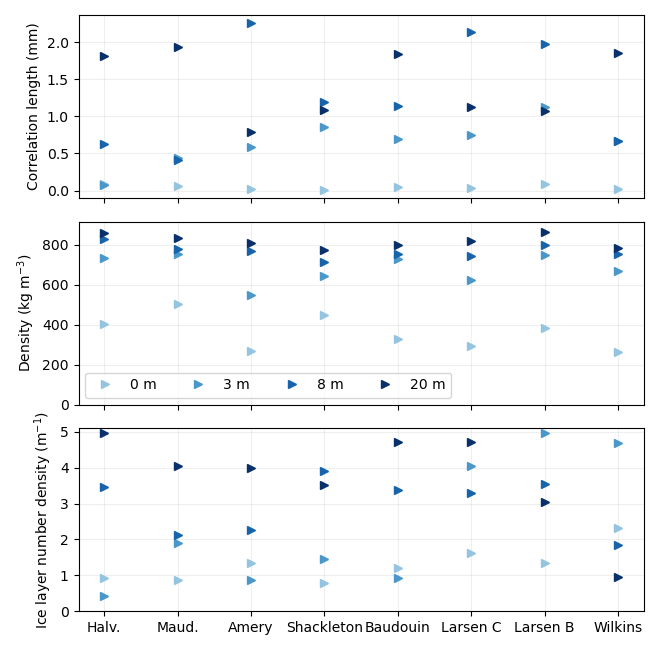

In [18]:


f, axs = plt.subplots(3, 1, figsize=(6.6, 6.5))

cmap = cm.Blues

wprops = props['winter']

for j in range(4):
    color = cmap(int(255 * (j + 2) / 5.))
    axs[0].plot(site_name(wprops.index), wprops[f'grain_size_{j}'], '>', color=color)
    axs[1].plot(site_name(wprops.index), wprops[f'density_{j}'], '>', color=color, label=f'{depth_v2[j]} m')
    axs[2].plot(site_name(wprops.index), wprops[f'layering_{j}'], '>', color=color)

axs[1].set_ylim((0, 917))
axs[2].set_ylim((0, 5.1))
                          
#axs[0].set_ylabel("Microwave grain size (mm)")
axs[0].set_ylabel("Correlation length (mm)")
axs[1].set_ylabel("Density (kg m$^{-3}$)")
axs[2].set_ylabel("Ice layer number density (m$^{-1}$)")
for i in [0, 1]:
    axs[i].set_xticklabels([])
for i in [0, 1, 2]:
    axs[i].grid(alpha=0.2)
plt.tight_layout()
axs[1].legend(ncol=4)

plt.savefig(f'fig-parameters-winter-experiment0.pdf')